## Get required modules imported

In [1]:
import copy
import numpy as NP
from scipy import stats
from astropy.stats import sigma_clipped_stats, histogram
import matplotlib.pyplot as PLT
import matplotlib.colors as PLTC
import matplotlib.ticker as PLTick
import yaml, argparse, warnings
import progressbar as PGB
import prisim
from prisim import bispectrum_phase as BSP
from IPython.core.debugger import set_trace
%matplotlib inline

### Print PRISim version 

In [2]:
print(prisim.__githash__)

bb083bc1abd3ef44d0b18c094fedfe3dc30ed6ac


## Read YAML file containing input parameters

In [36]:
inparmsfile = '/lustre/aoc/users/nthyagar/codes/mine/python/projects/closure/combine_pol_multiday_EQ28_data_RA_1.6_transit_closure_PS_analysis_parms.yaml'
with open(inparmsfile, 'r') as parms_file:
    parms = yaml.safe_load(parms_file)

In [26]:
print(parms)

{'plot': {'2d': {'action': True, 'kbin_min': None, 'kbin_max': None, 'kbintype': 'linear', 'num_kbins': None}, '2': {'datapool': ['whole'], 'nsigma': 1.0, 'spw': [0, 1], 'action': True, 'statistic': 'median', 'units': 'K', 'errtype': ['ssdiff'], 'sampling': 'resampled'}, '2c_err': {'action': True}, '2c': {'kprll_min': 0.85, 'action': True, 'diagoffsets_b': [[[0], [1], [0]], [[0], [1], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [-1, 0, 1], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]], 'diagoffsets_a': [[[0], [0]], [[0], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]], [[0], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22

## Parse YAML file and obtain input parameters

In [5]:
datadirs = parms['dirStruct']['datadirs']
infiles_a = parms['dirStruct']['infiles_a']
infiles_a_errinfo = parms['dirStruct']['err_infiles_a']
infiles_b = parms['dirStruct']['infiles_b']
infiles_b_errinfo = parms['dirStruct']['err_infiles_b']
model_labels = parms['dirStruct']['modelinfo']['model_labels']
mdldirs = parms['dirStruct']['modelinfo']['mdldirs']
mdl_infiles_a = parms['dirStruct']['modelinfo']['infiles_a']
mdl_infiles_a_errinfo = parms['dirStruct']['modelinfo']['err_infiles_a']
mdl_infiles_b = parms['dirStruct']['modelinfo']['infiles_b']
mdl_infiles_b_errinfo = parms['dirStruct']['modelinfo']['err_infiles_b']
outdir = parms['dirStruct']['outdir']
figdir = outdir + parms['dirStruct']['figdir']
plotfile_pfx = parms['dirStruct']['plotfile_pfx']

## Initialize data cross-power spectra

In [6]:
xcpdps_a = []
excpdps_a = []
xcpdps_b = []
excpdps_b = []
for fileind,indir in enumerate(datadirs):
    infile_a = indir + infiles_a[fileind]
    infile_a_errinfo = indir + infiles_a_errinfo[fileind]
    infile_b = indir + infiles_b[fileind]
    infile_b_errinfo = indir + infiles_b_errinfo[fileind]

    xcpdps_a += [BSP.read_CPhase_cross_power_spectrum(infile_a)]
    excpdps_a += [BSP.read_CPhase_cross_power_spectrum(infile_a_errinfo)]
    xcpdps_b += [BSP.read_CPhase_cross_power_spectrum(infile_b)]
    excpdps_b += [BSP.read_CPhase_cross_power_spectrum(infile_b_errinfo)]

## Incoherently average cross-power spectra of two polarizations

### Incoherently average cross-power spectra of two polarizations of data

In [7]:
xcpdps_a_avg_pol, excpdps_a_avg_pol = BSP.incoherent_cross_power_spectrum_average(xcpdps_a, excpdps=excpdps_a, diagoffsets=None)
xcpdps_b_avg_pol, excpdps_b_avg_pol = BSP.incoherent_cross_power_spectrum_average(xcpdps_b, excpdps=excpdps_b, diagoffsets=None)

## Initialize and average cross-power spectra of models from two polarizations

In [8]:
models_xcpdps_a_avg_pol = []
models_excpdps_a_avg_pol = []
models_xcpdps_b_avg_pol = []
models_excpdps_b_avg_pol = []
for mdlind, model in enumerate(model_labels):
    mdl_xcpdps_a = []
    mdl_excpdps_a = []
    mdl_xcpdps_b = []
    mdl_excpdps_b = []
    for fileind,mdldir in enumerate(mdldirs[mdlind]):
        mdl_infile_a = mdldir + mdl_infiles_a[mdlind][fileind]
        mdl_infile_a_errinfo = mdldir + mdl_infiles_a_errinfo[mdlind][fileind]
        mdl_infile_b = mdldir + mdl_infiles_b[mdlind][fileind]
        mdl_infile_b_errinfo = mdldir + mdl_infiles_b_errinfo[mdlind][fileind]

        mdl_xcpdps_a += [BSP.read_CPhase_cross_power_spectrum(mdl_infile_a)]
        mdl_excpdps_a += [BSP.read_CPhase_cross_power_spectrum(mdl_infile_a_errinfo)]
        mdl_xcpdps_b += [BSP.read_CPhase_cross_power_spectrum(mdl_infile_b)]
        mdl_excpdps_b += [BSP.read_CPhase_cross_power_spectrum(mdl_infile_b_errinfo)]
    mdl_xcpdps_a_avg_pol, mdl_excpdps_a_avg_pol = BSP.incoherent_cross_power_spectrum_average(mdl_xcpdps_a, excpdps=mdl_excpdps_a, diagoffsets=None)
    models_xcpdps_a_avg_pol += [mdl_xcpdps_a_avg_pol]
    models_excpdps_a_avg_pol += [mdl_excpdps_a_avg_pol]
    mdl_xcpdps_b_avg_pol, mdl_excpdps_b_avg_pol = BSP.incoherent_cross_power_spectrum_average(mdl_xcpdps_b, excpdps=mdl_excpdps_b, diagoffsets=None)
    models_xcpdps_b_avg_pol += [mdl_xcpdps_b_avg_pol]
    models_excpdps_b_avg_pol += [mdl_excpdps_b_avg_pol]

## Gather info on plots to be made

In [37]:
plot_info = parms['plot']
plots = [key for key in plot_info if plot_info[key]['action']]
print(plots)

['2d', '2', '2c_err', '2c']


## Plot 2: Plot closure phase delay power spectra

In [10]:
if ('2' in plots) or ('2a' in plots) or ('2b' in plots) or ('2c' in plots) or ('2d' in plots):

    sampling = plot_info['2']['sampling']
    statistic = plot_info['2']['statistic']
    datapool = plot_info['2']['datapool']
    pspec_unit_type = plot_info['2']['units']

    if pspec_unit_type == 'K':
        pspec_unit = 'mK2 Mpc3'
    else:
        pspec_unit = 'Jy2 Mpc'

    spw = plot_info['2']['spw']
    if spw is None:
        spwind = NP.arange(xcpdps2_a[sampling]['z'].size)
    else:
        spwind = NP.asarray(spw)

    if statistic is None:
        statistic = ['mean', 'median']
    else:
        statistic = [statistic]
        
    ps_errtype = plot_info['2']['errtype']
    errshade = {}
    for errtype in ps_errtype:
        if errtype.lower() == 'ssdiff':
            errshade[errtype] = '0.8'
        elif errtype.lower() == 'psdiff':
            errshade[errtype] = '0.6'

    nsigma = plot_info['2']['nsigma']

    mdl_colrs = ['red', 'green', 'blue', 'cyan', 'gray', 'orange']

## Plot 2c: Plot PS after incoherent averaging over redundant triads, LST diff range, and/or other polarization.

In [11]:
    if ('2c' in plots) or ('2d' in plots):
        kprll_min_for_rms = plot_info['2c']['kprll_min']
        if kprll_min_for_rms is None:
            kprll_min_for_rms = 0.0
        avg_incohax_a = plot_info['2c']['incohax_a']
        diagoffsets_incohax_a = plot_info['2c']['diagoffsets_a']
        diagoffsets_a = []
        avg_incohax_b = plot_info['2c']['incohax_b']
        diagoffsets_incohax_b = plot_info['2c']['diagoffsets_b']
        diagoffsets_b = []
        for combi,incax_comb in enumerate(avg_incohax_a):
            diagoffsets_a += [{}]
            for incaxind,incax in enumerate(incax_comb):
                diagoffsets_a[-1][incax] = NP.asarray(diagoffsets_incohax_a[combi][incaxind])
        xcpdps_a_avg_pol_diag, excpdps_a_avg_pol_diag = BSP.incoherent_cross_power_spectrum_average(xcpdps_a_avg_pol, excpdps=excpdps_a_avg_pol, diagoffsets=diagoffsets_a)

        models_xcpdps_a_avg_pol_diag = []
        models_excpdps_a_avg_pol_diag = []

        for combi,incax_comb in enumerate(avg_incohax_b):
            diagoffsets_b += [{}]
            for incaxind,incax in enumerate(incax_comb):
                diagoffsets_b[-1][incax] = NP.asarray(diagoffsets_incohax_b[combi][incaxind])

        xcpdps_b_avg_pol_diag, excpdps_b_avg_pol_diag = BSP.incoherent_cross_power_spectrum_average(xcpdps_b_avg_pol, excpdps=excpdps_b_avg_pol, diagoffsets=diagoffsets_b)
        models_xcpdps_b_avg_pol_diag = []
        models_excpdps_b_avg_pol_diag = []

        if len(model_labels) > 0:
            progress = PGB.ProgressBar(widgets=[PGB.Percentage(), PGB.Bar(marker='-', left=' |', right='| '), PGB.Counter(), '/{0:0d} Models '.format(len(model_labels)), PGB.ETA()], maxval=len(model_labels)).start()

            for i in range(len(model_labels)):
                model_xcpdps_a_avg_pol_diag, model_excpdps_a_avg_pol_diag = BSP.incoherent_cross_power_spectrum_average(models_xcpdps_a_avg_pol[i], excpdps=models_excpdps_a_avg_pol[i], diagoffsets=diagoffsets_a)
                models_xcpdps_a_avg_pol_diag += [copy.deepcopy(model_xcpdps_a_avg_pol_diag)]
                models_excpdps_a_avg_pol_diag += [copy.deepcopy(model_excpdps_a_avg_pol_diag)]

                model_xcpdps_b_avg_pol_diag, model_excpdps_b_avg_pol_diag = BSP.incoherent_cross_power_spectrum_average(models_xcpdps_b_avg_pol[i], excpdps=models_excpdps_b_avg_pol[i], diagoffsets=diagoffsets_b)
                models_xcpdps_b_avg_pol_diag += [copy.deepcopy(model_xcpdps_b_avg_pol_diag)]
                models_excpdps_b_avg_pol_diag += [copy.deepcopy(model_excpdps_b_avg_pol_diag)]

                progress.update(i+1)
            progress.finish()

100% |-----------------------------------------------| 2/2 Models Time: 0:00:07


In [16]:
        print(excpdps_a_avg_pol_diag['resampled']['errinfo']['median'][2].shape)
        print(excpdps_b_avg_pol_diag['resampled']['errinfo']['median'][2].shape)
#         print('==========================')
#         print(excpdps_a_avg_pol_diag['resampled']['errinfo']['median'][2])
#         print('--------------------------')
#         print(excpdps_b_avg_pol_diag['resampled']['errinfo']['median'][2])

(2, 1, 3, 1, 103)
(2, 1, 3, 1, 103)


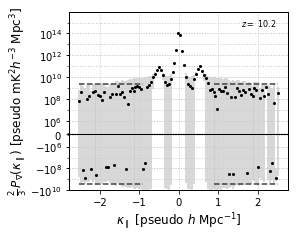

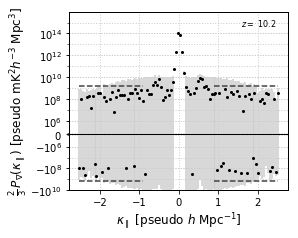

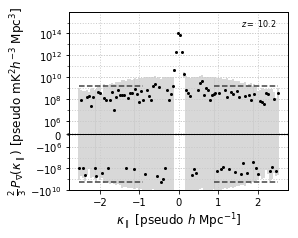

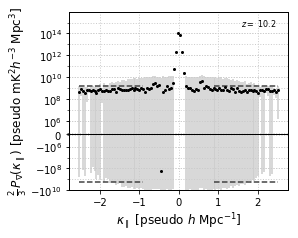

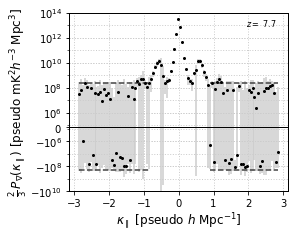

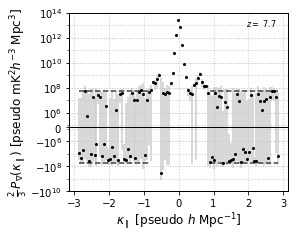

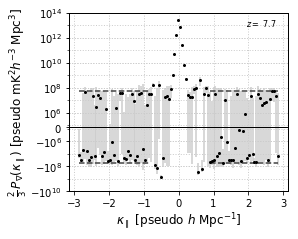

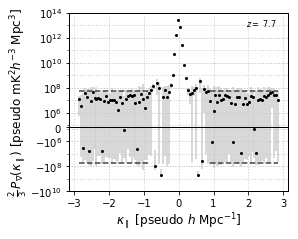

In [23]:
        if '2c' in plots:

#             ylim = {0: [-1e4, 1e9], 1: [-1e4, 1e8]} # keys are spw indices            
#             linthreshy = 1e0
            ylim = {0: [-1e10, 1e16], 1: [-1e10, 1e14]} # keys are spw indices
            linthreshy = 9e5

            lstind = [0]
            triadind = [0]
            dayind = [0]
            dayind_models = NP.zeros(len(model_labels), dtype=int).reshape(1,-1)

            for stat in statistic:
                for zind in spwind:
                    kprll_ind_for_rms = NP.where(NP.abs(excpdps_b_avg_pol_diag[sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
                    kprll_for_rms = excpdps_b_avg_pol_diag[sampling]['kprll'][zind,kprll_ind_for_rms]
                    for lind in lstind:
                        for di,dind in enumerate(dayind):
                            for combi in range(len(diagoffsets_b)):
                                maxabsvals = []
                                minabsvals = []
                                maxvals = []
                                minvals = []

                                fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 3.6))
                                if len(datapool) == 1:
                                    axs = [axs]
                                for dpoolind,dpool in enumerate(datapool):
                                    for trno,trind in enumerate(triadind):
#                                         if len(model_labels) > 0:
#                                             for mdlind, mdl in enumerate(model_labels):
#                                                 if dpool in models_xcpdps_b_avg_pol_diag[mdlind][sampling]:
#                                                     psval = (2/3.0) * models_xcpdps_b_avg_pol_diag[mdlind][sampling][dpool][stat][combi][zind,lind,dayind_models[di][mdlind],trind,:].to(pspec_unit).value
#                                                     maxabsvals += [NP.abs(psval.real).max()]
#                                                     minabsvals += [NP.abs(psval.real).min()]
#                                                     maxvals += [psval.real.max()]
#                                                     minvals += [psval.real.min()]
#                                                     axs[dpoolind].plot(models_xcpdps_b_avg_pol_diag[mdlind][sampling]['kprll'][zind,:], psval.real, ls='none', marker='.', ms=3, color=mdl_colrs[mdlind], label='{0}'.format(mdl))

                                        if dpool in xcpdps_b_avg_pol_diag[sampling]:
                                            psval = (2/3.0) * xcpdps_b_avg_pol_diag[sampling][dpool][stat][combi][zind,lind,dind,trind,:].to(pspec_unit).value
                                            ps_ssdiff = (2/3.0) * excpdps_b_avg_pol_diag[sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_for_rms].to(pspec_unit).value # Single RMS across all k_prll bins
                                            psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps_b_avg_pol_diag[sampling]['errinfo'][stat][combi][zind,lind,:,trind,:], axis=0).to(pspec_unit).value # RMS per k_prll bin
                                            if 2 in avg_incohax_b[combi]:
                                                ind_dayax_in_incohax = avg_incohax_b[combi].index(2)
                                                if 0 in diagoffsets_incohax_b[combi][ind_dayax_in_incohax]:
                                                    rms_inflation_factor = 2.0 * NP.sqrt(2.0)
                                                else:
                                                    rms_inflation_factor = NP.sqrt(2.0)
                                            else:
                                                rms_inflation_factor = NP.sqrt(2.0)
                                            psrms_psdiff = (2/3.0) * (xcpdps_a_avg_pol_diag[sampling][dpool][stat][combi][zind,lind,1,1,trind,:] - xcpdps_a_avg_pol_diag[sampling][dpool][stat][combi][zind,lind,0,0,trind,:]).to(pspec_unit).value
                                            psrms_psdiff = NP.abs(psrms_psdiff.real) / rms_inflation_factor

                                            psrms_max = NP.amax(NP.vstack((psrms_ssdiff, psrms_psdiff)), axis=0)

                                            maxabsvals += [NP.abs(psval.real + nsigma*psrms_max).max()]
                                            minabsvals += [NP.abs(psval.real).min()]
                                            maxvals += [(psval.real + nsigma*psrms_max).max()]
                                            minvals += [(psval.real - nsigma*psrms_max).min()]

                                            for errtype in ps_errtype:
                                                if errtype.lower() == 'ssdiff':
                                                    axs[dpoolind].errorbar(xcpdps_b_avg_pol_diag[sampling]['kprll'][zind,:], psval.real, yerr=nsigma*psrms_ssdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black')
                                                    psmean_ssdiff_across_kbins, psmedian_ssdiff_across_kbins, psrms_ssdiff_across_kbins = sigma_clipped_stats(NP.vstack((ps_ssdiff.real, ps_ssdiff.imag)))
                                                    pos_kprll_ind_for_rms = NP.where(kprll_for_rms >= 0.0)[0]
                                                    neg_kprll_ind_for_rms = NP.where(kprll_for_rms <= 0.0)[0]
                                                    axs[dpoolind].hlines([-psrms_ssdiff_across_kbins, psrms_ssdiff_across_kbins], kprll_for_rms[pos_kprll_ind_for_rms].min(), kprll_for_rms[pos_kprll_ind_for_rms].max(), linestyles='--', lw=1.5, color='0.25')
                                                    axs[dpoolind].hlines([-psrms_ssdiff_across_kbins, psrms_ssdiff_across_kbins], kprll_for_rms[neg_kprll_ind_for_rms].min(), kprll_for_rms[neg_kprll_ind_for_rms].max(), linestyles='--', lw=1.5, color='0.25')
                                                elif errtype.lower() == 'psdiff':
                                                    axs[dpoolind].errorbar(xcpdps_b_avg_pol_diag[sampling]['kprll'][zind,:], psval.real, yerr=nsigma*psrms_psdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black', label='FG+N')

#                                         legend = axs[dpoolind].legend(loc='center', bbox_to_anchor=(0.5,0.3), shadow=False, fontsize=8)
                                        if trno == 0:
                                            axs[dpoolind].text(0.95, 0.97, r'$z=$'+' {0:.1f}'.format(xcpdps_b_avg_pol_diag[sampling]['z'][zind]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='right', va='top', color='black')

#                                         axt = axs[dpoolind].twiny()
#                                         axt.set_xlim(1e6*xcpdps_b_avg_pol_diag[sampling]['lags'].min(), 1e6*xcpdps_b_avg_pol_diag[sampling]['lags'].max())

                                    axs[dpoolind].axhline(y=0, xmin=0, xmax=1, ls='-', lw=1, color='black')

                                    minvals = NP.asarray(minvals)
                                    maxvals = NP.asarray(maxvals)
                                    minabsvals = NP.asarray(minabsvals)
                                    maxabsvals = NP.asarray(maxabsvals)
#                                     axs[dpoolind].set_xlim(0.99*xcpdps_b_avg_pol_diag[sampling]['kprll'][zind,:].min(), 1.01*xcpdps_b_avg_pol_diag[sampling]['kprll'][zind,:].max())
#                                     axs[dpoolind].set_xlim(-2.5, 2.5)
#                                     if NP.min(minvals) < 0.0:
#                                         axs[dpoolind].set_ylim(1.5*NP.min(minvals), 2*NP.max(maxabsvals))
#                                     else:
#                                         axs[dpoolind].set_ylim(0.5*NP.min(minvals), 2*NP.max(maxabsvals))
                                    axs[dpoolind].set_ylim(ylim[zind])                                    
                                    
#                                     axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
#                                     tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)
                                    axs[dpoolind].set_yscale('symlog', linthreshy=linthreshy)
                                    tickloc = PLTick.SymmetricalLogLocator(linthresh=linthreshy, base=100.0)

                                    axs[dpoolind].yaxis.set_major_locator(tickloc)
                                    yticklocs = NP.asarray(axs[dpoolind].get_yticks())
                                    ytickspacings = NP.diff(yticklocs)
                                    tickinds_to_remove = NP.setdiff1d(NP.where(NP.abs(yticklocs)<=linthreshy)[0], NP.argmin(NP.abs(yticklocs)))
                                    if tickinds_to_remove.size > 0:
                                        new_yticklocs = yticklocs[NP.setdiff1d(NP.arange(yticklocs.size), tickinds_to_remove)]
                                        axs[dpoolind].yaxis.set_major_locator(PLTick.FixedLocator((new_yticklocs.tolist())))
                                    axs[dpoolind].grid(color='0.8', which='both', linestyle=':', lw=1)

                                fig.subplots_adjust(top=0.85)
                                fig.subplots_adjust(bottom=0.16)
                                fig.subplots_adjust(left=0.22)
                                fig.subplots_adjust(right=0.98)

                                big_ax = fig.add_subplot(111)
                                big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
                                # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
                                big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
                                big_ax.set_xticks([])
                                big_ax.set_yticks([])
                                big_ax.set_xlabel(r'$\kappa_\parallel$'+' [pseudo '+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium', labelpad=20)
                                if pspec_unit_type == 'K':
                                    big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo mK$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium', labelpad=40)
                                else:
                                    big_ax.set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo Jy$^2h^{-1}$ Mpc]', fontsize=12, weight='medium', labelpad=40)

                                big_axt = big_ax.twiny()
                                big_axt.set_xticks([])
#                                 big_axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]', fontsize=12, weight='medium', labelpad=20)

                                PLT.savefig(figdir + '{0}_symlog_incoh_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_comb_{5:0d}.pdf'.format(plotfile_pfx, xcpdps_b_avg_pol_diag[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps_b_avg_pol_diag['dlst'][0], combi), bbox_inches=0)

## Plot 2c_err: PS Error analysis after incoherent averaging over redundant triads, LST diff range

In [33]:
        print(len(excpdps_b))
        print(excpdps_b[0]['resampled']['errinfo']['median'].shape)

2
(2, 2, 3, 61, 103)


In [35]:
        if '2c_err' in plots:
            lstind = [0]
            triadind = [0]
            dayind = [0]
            
            for stat in statistic:
                print(stat)
                print('=======================================')
                for zind in spwind:
                    kprll_ind_current_for_rms = NP.where(NP.abs(excpdps_b_avg_pol_diag[sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
                    kprll_current_for_rms = excpdps_b_avg_pol_diag[sampling]['kprll'][zind,kprll_ind_current_for_rms]
#                     kprll_ind_other0_for_rms = NP.where(NP.abs(excpdps_b[0][sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
#                     kprll_other0_for_rms = excpdps_b[0][sampling]['kprll'][zind,kprll_ind_other0_for_rms]
#                     kprll_ind_other1_for_rms = NP.where(NP.abs(excpdps_b[1][sampling]['kprll'][zind,:]) >= kprll_min_for_rms)[0]
#                     kprll_other1_for_rms = excpdps_b[1][sampling]['kprll'][zind,kprll_ind_other1_for_rms]
                    for lind in lstind:
                        for dpoolind,dpool in enumerate(datapool):
                            for di,dind in enumerate(dayind):
                                for trno,trind in enumerate(triadind):
                                    for combi in range(len(diagoffsets_b)):
                                        ps_ssdiff_current = (2/3.0) * excpdps_b_avg_pol_diag[sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_current_for_rms].to(pspec_unit).value
#                                         ps_ssdiff_other0 = (2/3.0) * excpdps_b[0][sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_other0_for_rms].to(pspec_unit).value
#                                         ps_ssdiff_other1 = (2/3.0) * excpdps_b[1][sampling]['errinfo'][stat][combi][zind,lind,:,trind,kprll_ind_other1_for_rms].to(pspec_unit).value
                                        hist_current_real, hist_current_real_bins = histogram(ps_ssdiff_current.real.ravel(), bins='knuth', density=False)
#                                         hist_other0_real, hist_other0_real_bins = histogram(ps_ssdiff_other0.real.ravel(), bins='knuth', density=False)
#                                         hist_other1_real, hist_other1_real_bins = histogram(ps_ssdiff_other1.real.ravel(), bins='knuth', density=False)
                                        hist_current_imag, hist_current_imag_bins = histogram(ps_ssdiff_current.imag.ravel(), bins='knuth', density=False)
#                                         hist_other0_imag, hist_other0_imag_bins = histogram(ps_ssdiff_other0.imag.ravel(), bins='knuth', density=False)
#                                         hist_other1_imag, hist_other1_imag_bins = histogram(ps_ssdiff_other1.imag.ravel(), bins='knuth', density=False)
                                        hist_current, hist_current_bins = histogram(NP.vstack((ps_ssdiff_current.real,ps_ssdiff_current.imag)).ravel(), bins='knuth', density=False)
#                                         hist_other0, hist_other0_bins = histogram(NP.vstack((ps_ssdiff_other0.real,ps_ssdiff_other0.imag)).ravel(), bins='knuth', density=False)
#                                         hist_other1, hist_other1_bins = histogram(NP.vstack((ps_ssdiff_other1.real,ps_ssdiff_other1.imag)).ravel(), bins='knuth', density=False)

                                        current_real_mean, current_real_median, current_real_std = sigma_clipped_stats(ps_ssdiff_current.real) 
                                        current_imag_mean, current_imag_median, current_imag_std = sigma_clipped_stats(ps_ssdiff_current.imag)
                                        current_mean, current_median, current_std = sigma_clipped_stats(NP.vstack((ps_ssdiff_current.real, ps_ssdiff_current.imag)))
#                                         other0_real_mean, other0_real_median, other0_real_std = sigma_clipped_stats(ps_ssdiff_other0.real) 
#                                         other0_imag_mean, other0_imag_median, other0_imag_std = sigma_clipped_stats(ps_ssdiff_other0.imag)
#                                         other0_mean, other0_median, other0_std = sigma_clipped_stats(NP.vstack((ps_ssdiff_other0.real, ps_ssdiff_other0.imag)))
#                                         other1_real_mean, other1_real_median, other1_real_std = sigma_clipped_stats(ps_ssdiff_other1.real) 
#                                         other1_imag_mean, other1_imag_median, other1_imag_std = sigma_clipped_stats(ps_ssdiff_other1.imag)
#                                         other1_mean, other1_median, other1_std = sigma_clipped_stats(NP.vstack((ps_ssdiff_other1.real, ps_ssdiff_other1.imag)))

#                                         real_kval, real_pval = stats.ks_2samp(ps_ssdiff_current.real.ravel(), ps_ssdiff_other.real.ravel())
#                                         imag_kval, imag_pval = stats.ks_2samp(ps_ssdiff_current.imag.ravel(), ps_ssdiff_other.imag.ravel())
#                                         kval, pval = stats.ks_2samp(NP.vstack((ps_ssdiff_other.real, ps_ssdiff_other.imag)).ravel(), NP.vstack((ps_ssdiff_current.real, ps_ssdiff_current.imag)).ravel())

                                        print('===================')
                                        print('SpW: {0}, Diagcomb: {1}'.format(zind, combi))
                                        print('-------------------')
                                        print('Current (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_real_mean, current_real_median, current_real_std))
#                                         print('Other0 (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other0_real_mean, other0_real_median, other0_real_std))
#                                         print('Other1 (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other1_real_mean, other1_real_median, other1_real_std))
#                                         print('K-S (real): k-val = {0},\t p-val = {1}'.format(real_kval, real_pval))

                                        print('\nCurrent (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_imag_mean, current_imag_median, current_imag_std))
#                                         print('Other0 (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other0_imag_mean, other0_imag_median, other0_imag_std))
#                                         print('Other1 (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(other1_imag_mean, other1_imag_median, other1_imag_std))
#                                         print('K-S (imag): k-val = {0},\t p-val = {1}'.format(imag_kval, imag_pval))

                                        print('\nCurrent: Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_mean, current_median, current_std))
#                                         print('Other0: Mean = {0},\t Median = {1},\t RMS = {2}'.format(other0_mean, other0_median, other0_std))
#                                         print('Other1: Mean = {0},\t Median = {1},\t RMS = {2}'.format(other1_mean, other1_median, other1_std))
#                                         print('K-S: k-val = {0},\t p-val = {1}'.format(kval, pval))

#                                         fig, axs = PLT.subplots(nrows=3, sharex=True, sharey=True, figsize=(4.0, 4.5))
#                                         hist_current_real, hist_current_real_bins, patches = axs[0].hist(ps_ssdiff_current.real.ravel(), bins=hist_current_real_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0} (real)'.format(current_label))
#                                         hist_other_real, hist_other_real_bins, patches = axs[0].hist(ps_ssdiff_other.real.ravel(), bins=hist_other_real_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0} (real)'.format(other_label))
#                                         hist_current_imag, hist_current_imag_bins, patches = axs[1].hist(ps_ssdiff_current.imag.ravel(), bins=hist_current_imag_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0} (imag)'.format(current_label))
#                                         hist_other_imag, hist_other_imag_bins, patches = axs[1].hist(ps_ssdiff_other.imag.ravel(), bins=hist_other_imag_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0} (imag)'.format(other_label))
#                                         hist_current, hist_current_bins, patches = axs[2].hist(NP.vstack((ps_ssdiff_current.real,ps_ssdiff_current.imag)).ravel(), bins=hist_current_bins, density=False, histtype='step', ls='-', color='black', lw=2, label='{0}'.format(current_label))
#                                         hist_other, hist_other_bins, patches = axs[2].hist(NP.vstack((ps_ssdiff_other.real,ps_ssdiff_other.imag)).ravel(), bins=hist_current_bins, density=False, histtype='step', ls='-', color='gray', lw=2, label='{0}'.format(other_label))
                                        
#                                         axs[0].legend(loc='upper right')
#                                         axs[1].legend(loc='upper right')
#                                         axs[2].legend(loc='upper right')
#                                         axs[2].set_xlim(-5*other_std, 5*other_std)
                     
#                                         fig.subplots_adjust(hspace=0, wspace=0)
                                        

median
SpW: 0, Diagcomb: 0
-------------------
Current (real): Mean = -1518178091.43,	 Median = -2014600620.45,	 RMS = 4561390886.12

Current (imag): Mean = 106884080.395,	 Median = 64712829.9024,	 RMS = 1808517073.64

Current: Mean = -828806775.812,	 Median = -1115032234.55,	 RMS = 2405509441.43
SpW: 0, Diagcomb: 1
-------------------
Current (real): Mean = -1633421838.71,	 Median = -2062364468.79,	 RMS = 4484633547.19

Current (imag): Mean = 73651423.0512,	 Median = 138983611.694,	 RMS = 754978383.845

Current: Mean = -680320222.906,	 Median = -494389696.381,	 RMS = 1532426608.65
SpW: 0, Diagcomb: 2
-------------------
Current (real): Mean = -1637088349.03,	 Median = -2059613054.46,	 RMS = 4485827081.84

Current (imag): Mean = 72033343.0204,	 Median = 143494348.678,	 RMS = 772854868.053

Current: Mean = -680560714.512,	 Median = -503330810.063,	 RMS = 1582281096.42
SpW: 0, Diagcomb: 3
-------------------
Current (real): Mean = -1637088349.03,	 Median = -2059613054.46,	 RMS = 44858270

## Plot 2d: Plot PS after incoherent averaging over k-bins, in standard PS and Delta^2 units

In [38]:
        if '2d' in plots:
            kbin_min = plot_info['2d']['kbin_min']
            kbin_max = plot_info['2d']['kbin_max']
            num_kbins = plot_info['2d']['num_kbins']
            kbintype = plot_info['2d']['kbintype']
            kprll_min_for_rms = plot_info['2d']['kprll_min_rms']
            if kprll_min_for_rms is None:
                kprll_min_for_rms = 0.0
            
            if (kbin_min is None) or (kbin_max is None):
                kbins = None
            else:
                if num_kbins is None:
                    raise ValueError('Input num_kbins must be set if kbin range is provided')
                if kbintype == 'linear':
                    kbins = NP.linspace(kbin_min, kbin_max, num=num_kbins, endpoint=True)
                elif kbintype == 'log':
                    if kbin_min > 0.0:
                        kbins = NP.geomspace(kbin_min, kbin_max, num=num_kbins, endpoint=True)
                    elif kbin_min == 0.0:
                        eps_k = 1e-3
                        kbins = NP.geomspace(kbin_min+eps_k, kbin_max, num=num_kbins, endpoint=True)
                    else:
                        eps_k = 1e-3
                        kbins_pos = NP.geomspace(eps_k, kbin_max, num=num_kbins, endpoint=True)
                        ind_kbin_thresh = NP.argmin(kbins_pos[kbins_pos >= NP.abs(kbin_min)])
                        kbins_neg = -1 * kbins_pos[:ind_kbin_thresh+1][::-1]
                        kbins = NP.hstack((kbins_neg, kbins_pos))
                else:
                    raise ValueError('Input kbintype must be set to "linear" or "log"')
            xcpdps_a_avg_pol_diag_kbin = BSP.incoherent_kbin_averaging(xcpdps_a_avg_pol_diag, kbins=kbins, kbintype=kbintype)
            excpdps_a_avg_pol_diag_kbin = BSP.incoherent_kbin_averaging(excpdps_a_avg_pol_diag, kbins=kbins, kbintype=kbintype)
            models_xcpdps_a_avg_pol_diag_kbin = []
            models_excpdps_a_avg_pol_diag_kbin = []

            xcpdps_b_avg_pol_diag_kbin = BSP.incoherent_kbin_averaging(xcpdps_b_avg_pol_diag, kbins=kbins, kbintype=kbintype)
            excpdps_b_avg_pol_diag_kbin = BSP.incoherent_kbin_averaging(excpdps_b_avg_pol_diag, kbins=kbins, kbintype=kbintype)
            models_xcpdps_b_avg_pol_diag_kbin = []
            models_excpdps_b_avg_pol_diag_kbin = []

            if len(model_labels) > 0:
                for i in range(len(model_labels)):
                    models_xcpdps_a_avg_pol_diag_kbin += [BSP.incoherent_kbin_averaging(models_xcpdps_a_avg_pol_diag[i], kbins=kbins, kbintype=kbintype)]
                    models_excpdps_a_avg_pol_diag_kbin += [BSP.incoherent_kbin_averaging(models_excpdps_a_avg_pol_diag[i], kbins=kbins, kbintype=kbintype)]
                    models_xcpdps_b_avg_pol_diag_kbin += [BSP.incoherent_kbin_averaging(models_xcpdps_b_avg_pol_diag[i], kbins=kbins, kbintype=kbintype)]
                    models_excpdps_b_avg_pol_diag_kbin += [BSP.incoherent_kbin_averaging(models_excpdps_b_avg_pol_diag[i], kbins=kbins, kbintype=kbintype)]

/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)
100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=whole, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=whole, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=whole, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=submodel, stat=median, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=0, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=1, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=residual, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=0...
Processing datapool=residual, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |-----------------------------------------| 1025/1025 k-bins Time: 0:00:01
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=1, spw=1...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=2, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=0...
Processing datapool=errinfo, stat=mean, LST-Day-Triad combination=3, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=0, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=1, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=0...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=2, spw=1...
Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=0...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00
100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00


Processing datapool=errinfo, stat=median, LST-Day-Triad combination=3, spw=1...


100% |---------------------------------------------| 52/52 k-bins Time: 0:00:00




SpW: 0, Diagcomb: 0
-------------------

Current: Mean = -664090138.006,	 Median = -900075236.769,	 RMS = 2040633107.77


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal


/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/Binned_Data_0100_0220/EQ28/XX_YY/figures/EQ28_dualpol_data_symlog_incoh_kbin_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_comb_0.pdf

SpW: 0, Diagcomb: 1
-------------------

Current: Mean = -637399716.456,	 Median = -193337675.17,	 RMS = 1399102589.63
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/Binned_Data_0100_0220/EQ28/XX_YY/figures/EQ28_dualpol_data_symlog_incoh_kbin_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_comb_1.pdf

SpW: 0, Diagcomb: 2
-------------------

Current: Mean = -668584212.558,	 Median = -248477353.353,	 RMS = 1444806709.23
/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/Binned_Data_0100_0220/EQ28/XX_YY/figures/EQ28_dualpol_data_symlog_incoh_kbin_avg_real_cpdps_z_10.2_median_resampled_dlst_60.0s_comb_2.pdf

SpW: 0, Diagcomb: 3
-------------------

Current: Mean = -668584212.558,	 Median = -248477353.353,	 RMS = 1444806709.23
/lustre/aoc/projects/hera/nth

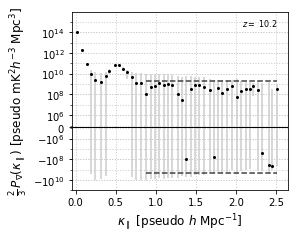

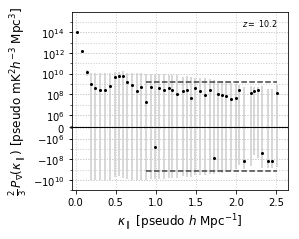

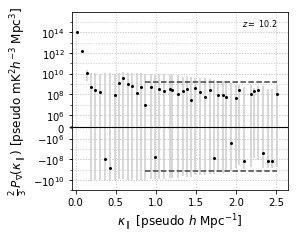

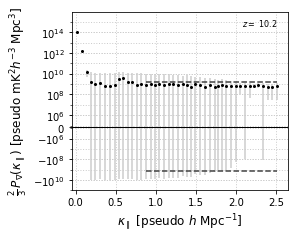

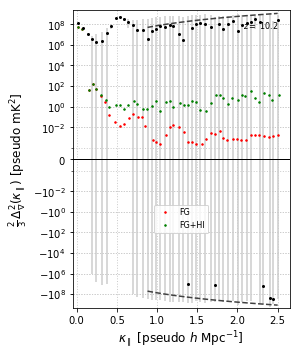

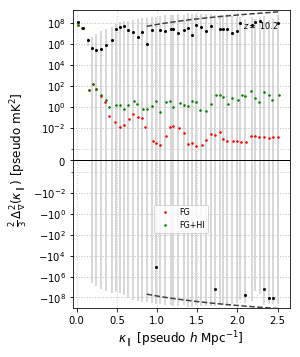

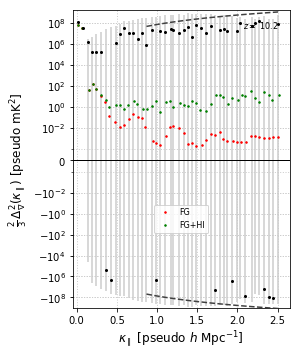

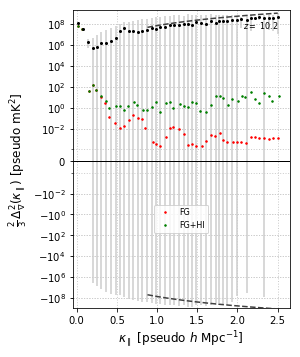

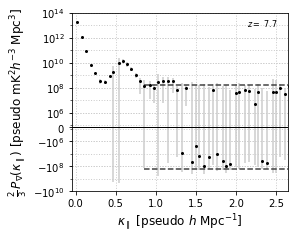

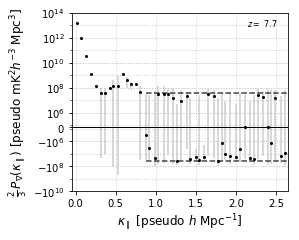

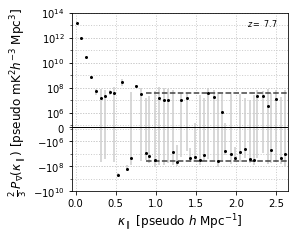

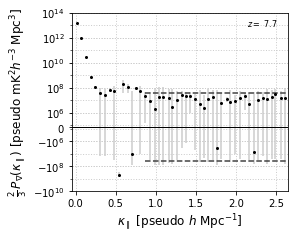

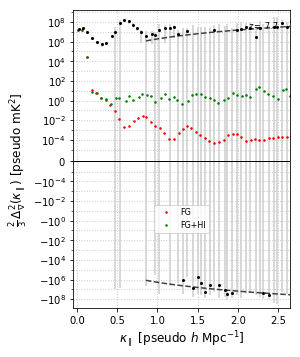

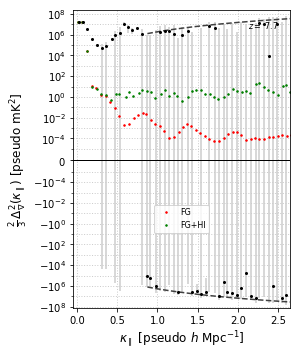

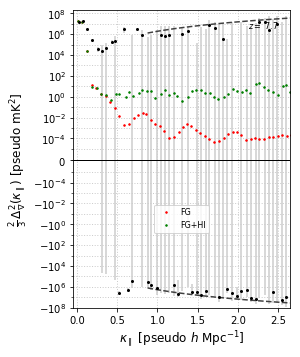

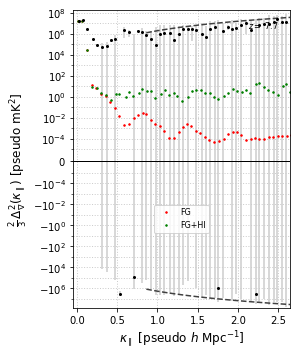

In [56]:
            ylim = {0: [-1e11, 1e16], 1: [-1e10, 1e14]} # keys are spw indices
            linthreshy = 9e5
#             ylim = {0: [-1e4, 1e9], 1: [-1e4, 1e8]} # keys are spw indices
#             linthreshy = 1e0

            lstind = [0]
            triadind = [0]
            dayind = [0]
            dayind_models = NP.zeros(len(model_labels), dtype=int).reshape(1,-1)

            for stat in statistic:
                for zind in spwind:
                    print('\n===================')
                    for lind in lstind:
                        for di,dind in enumerate(dayind):
                            for pstype in ['PS', 'Del2']:
                                for combi in range(len(diagoffsets_b)):
                                    print('\nSpW: {0}, Diagcomb: {1}'.format(zind, combi))
                                    maxabsvals = []
                                    minabsvals = []
                                    maxvals = []
                                    minvals = []
                                    if pstype == 'Del2':
                                        fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 6.0))
                                    else:
                                        fig, axs = PLT.subplots(nrows=1, ncols=len(datapool), sharex=True, sharey=True, figsize=(4.0*len(datapool), 3.6))
                                    if len(datapool) == 1:
                                        axs = [axs]
                                    for dpoolind,dpool in enumerate(datapool):
                                        for trno,trind in enumerate(triadind):
                                            if pstype == 'Del2':
                                                if len(model_labels) > 0:
                                                    for mdlind, mdl in enumerate(model_labels):
                                                        if dpool in models_xcpdps_b_avg_pol_diag_kbin[mdlind][sampling]:
                                                            if pstype == 'PS':
                                                                psval = (2/3.0) * models_xcpdps_b_avg_pol_diag_kbin[mdlind][sampling][dpool][stat][pstype][combi][zind,lind,dayind_models[di][mdlind],trind,:].to(pspec_unit).value
                                                            else:
                                                                psval = (2/3.0) * models_xcpdps_b_avg_pol_diag_kbin[mdlind][sampling][dpool][stat][pstype][combi][zind,lind,dayind_models[di][mdlind],trind,:].to('mK2').value
                                                            kval = models_xcpdps_b_avg_pol_diag_kbin[mdlind][sampling]['kbininfo'][dpool][stat][combi][zind,lind,dayind_models[di][mdlind],trind,:].to('Mpc-1').value
                                                            maxabsvals += [NP.nanmin(NP.abs(psval.real))]
                                                            minabsvals += [NP.nanmin(NP.abs(psval.real))]
                                                            maxvals += [NP.nanmax(psval.real)]
                                                            minvals += [NP.nanmin(psval.real)]
                                                            axs[dpoolind].plot(kval, psval.real, ls='none', marker='.', ms=3, color=mdl_colrs[mdlind], label='{0}'.format(mdl))

                                            if dpool in xcpdps_b_avg_pol_diag_kbin[sampling]:
                                                kval = xcpdps_b_avg_pol_diag_kbin[sampling]['kbininfo'][dpool][stat][combi][zind,lind,dind,trind,:].to('Mpc-1').value
                                                kprll_ind_for_rms = NP.where(NP.abs(kval) >= kprll_min_for_rms)[0]
                                                kprll_for_rms = kval[kprll_ind_for_rms]
                                                if pstype == 'PS':
                                                    psval = (2/3.0) * xcpdps_b_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,dind,trind,:].to(pspec_unit).value
                                                    ps_ssdiff = (2/3.0) * excpdps_b_avg_pol_diag_kbin[sampling]['errinfo'][stat][pstype][combi][zind,lind,:,trind,kprll_ind_for_rms].to(pspec_unit).value # Single RMS across all k_prll bins
                                                    psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps_b_avg_pol_diag_kbin[sampling]['errinfo'][stat][pstype][combi][zind,lind,:,trind,:], axis=0).to(pspec_unit).value # RMS per k_prll bin
                                                    psrms_psdiff = (2/3.0) * (xcpdps_a_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,1,1,trind,:] - xcpdps_a_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,0,0,trind,:]).to(pspec_unit).value
                                                else:
                                                    psval = (2/3.0) * xcpdps_b_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,dind,trind,:].to('mK2').value
                                                    psrms_ssdiff = (2/3.0) * NP.nanstd(excpdps_b_avg_pol_diag_kbin[sampling]['errinfo'][stat][pstype][combi][zind,lind,:,trind,:], axis=0).to('mK2').value
                                                    psrms_psdiff = (2/3.0) * (xcpdps_a_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,1,1,trind,:] - xcpdps_a_avg_pol_diag_kbin[sampling][dpool][stat][pstype][combi][zind,lind,0,0,trind,:]).to('mK2').value
#                                                     del2rms_ssdiff = ps_ssdiff * kprll_for_rms**3 / (2 * NP.pi**2)
                                                    
                                                if 2 in avg_incohax_b[combi]:
                                                    ind_dayax_in_incohax = avg_incohax_b[combi].index(2)
                                                    if 0 in diagoffsets_incohax_b[combi][ind_dayax_in_incohax]:
                                                        rms_inflation_factor = 2.0 * NP.sqrt(2.0)
                                                    else:
                                                        rms_inflation_factor = NP.sqrt(2.0)
                                                else:
                                                    rms_inflation_factor = NP.sqrt(2.0)
                                                psrms_psdiff = NP.abs(psrms_psdiff.real) / rms_inflation_factor
                                                psrms_max = NP.amax(NP.vstack((psrms_ssdiff, psrms_psdiff)), axis=0)

                                                maxabsvals += [NP.nanmax(NP.abs(psval.real + nsigma*psrms_max.real))]
                                                minabsvals += [NP.nanmin(NP.abs(psval.real))]
                                                maxvals += [NP.nanmax(psval.real + nsigma*psrms_max.real)]
                                                minvals += [NP.nanmin(psval.real - nsigma*psrms_max.real)]
                                                
                                                for errtype in ps_errtype:
                                                    if errtype.lower() == 'ssdiff':
                                                        axs[dpoolind].errorbar(kval, psval.real, yerr=nsigma*psrms_ssdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black')
                                                        if pstype == 'PS':
                                                            psmean_ssdiff_across_kbins, psmedian_ssdiff_across_kbins, psrms_ssdiff_across_kbins = sigma_clipped_stats(NP.vstack((ps_ssdiff.real, ps_ssdiff.imag)))
                                                            print('-------------------')
#                                                             print('Current (real): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_real_mean, current_real_median, current_real_std))
#                                                             print('\nCurrent (imag): Mean = {0},\t Median = {1},\t RMS = {2}'.format(current_imag_mean, current_imag_median, current_imag_std))
                                                            print('\nCurrent: Mean = {0},\t Median = {1},\t RMS = {2}'.format(psmean_ssdiff_across_kbins, psmedian_ssdiff_across_kbins, psrms_ssdiff_across_kbins))
                                                            axs[dpoolind].hlines([-psrms_ssdiff_across_kbins, psrms_ssdiff_across_kbins], kprll_for_rms.min(), kprll_for_rms.max(), linestyles='--', lw=1.5, color='0.25')
                                                        if pstype == 'Del2':
                                                            del2rms_ssdiff_across_kbins =  psrms_ssdiff_across_kbins * kprll_for_rms**3 / (2 * NP.pi**2)
                                                            axs[dpoolind].plot(kprll_for_rms, del2rms_ssdiff_across_kbins, ls='--', lw=1.5, color='0.25')
                                                            axs[dpoolind].plot(kprll_for_rms, -del2rms_ssdiff_across_kbins, ls='--', lw=1.5, color='0.25')
                                                    elif errtype.lower() == 'psdiff':
                                                        axs[dpoolind].errorbar(kval, psval.real, yerr=nsigma*psrms_psdiff, xerr=None, ecolor=errshade[errtype.lower()], ls='none', marker='.', ms=4, color='black', label='Data')
                                            if pstype == 'Del2':
                                                legend = axs[dpoolind].legend(loc='center', bbox_to_anchor=(0.5,0.3), shadow=False, fontsize=8)
                                            if trno == 0:
                                                axs[dpoolind].text(0.95, 0.97, r'$z=$'+' {0:.1f}'.format(xcpdps_b_avg_pol_diag_kbin['resampled']['z'][zind]), transform=axs[dpoolind].transAxes, fontsize=8, weight='medium', ha='right', va='top', color='black')
                                                
                                        axs[dpoolind].axhline(y=0, xmin=0, xmax=1, ls='-', lw=1, color='black')
                                        
                                        minvals = NP.asarray(minvals)
                                        maxvals = NP.asarray(maxvals)
                                        minabsvals = NP.asarray(minabsvals)
                                        maxabsvals = NP.asarray(maxabsvals)
                                        axs[dpoolind].set_xlim(0.99*NP.nanmin(xcpdps_b_avg_pol_diag_kbin['resampled']['kbininfo']['kbin_edges'][zind].to('Mpc-1').value), 1.01*NP.nanmax(xcpdps_b_avg_pol_diag_kbin['resampled']['kbininfo']['kbin_edges'][zind].to('Mpc-1').value))
                                        if pstype == 'PS':
                                            axs[dpoolind].set_ylim(ylim[zind]) 
                                            axs[dpoolind].set_yscale('symlog', linthreshy=linthreshy)
                                            tickloc = PLTick.SymmetricalLogLocator(linthresh=linthreshy, base=100.0)
                                        else:    
                                            if NP.min(minvals) < 0.0:
                                                axs[dpoolind].set_ylim(1.5*NP.nanmin(minvals), 2*NP.nanmax(maxabsvals))
                                            else:
                                                axs[dpoolind].set_ylim(0.5*NP.nanmin(minvals), 2*NP.nanmax(maxabsvals))
                                            axs[dpoolind].set_yscale('symlog', linthreshy=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))
                                            tickloc = PLTick.SymmetricalLogLocator(linthresh=10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))), base=100.0)
                                        axs[dpoolind].yaxis.set_major_locator(tickloc)
                                        
                                        yticklocs = NP.asarray(axs[dpoolind].get_yticks())
                                        ytickspacings = NP.diff(yticklocs)
                                        if pstype == 'PS':
                                            tickinds_to_remove = NP.setdiff1d(NP.where(NP.abs(yticklocs)<=linthreshy)[0], NP.argmin(NP.abs(yticklocs)))
                                        if pstype == 'Del2':
#                                             tickinds_to_remove = NP.asarray([])
                                            tickinds_to_remove = NP.setdiff1d(NP.where(NP.abs(yticklocs) <= 10**NP.floor(NP.log10(NP.min(minabsvals[minabsvals > 0.0]))))[0], NP.argmin(NP.abs(yticklocs)))
                                        if tickinds_to_remove.size > 0:
                                            new_yticklocs = yticklocs[NP.setdiff1d(NP.arange(yticklocs.size), tickinds_to_remove)]
                                            axs[dpoolind].yaxis.set_major_locator(PLTick.FixedLocator((new_yticklocs.tolist())))
                                        
                                        axs[dpoolind].grid(color='0.8', which='both', linestyle=':', lw=1)

                                    axs[dpoolind].set_xlim(-0.05, 2.65)
                                    axs[dpoolind].set_xlim(left=-0.05)
                                    axs[dpoolind].set_xlabel(r'$\kappa_\parallel$'+' [pseudo '+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium')
                                    if pstype == 'PS':
                                        axs[dpoolind].set_ylabel(r'$\frac{2}{3}\, P_\nabla(\kappa_\parallel)$ [pseudo mK$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium')
                                    else:
                                        axs[dpoolind].set_ylabel(r'$\frac{2}{3}\, \Delta_\nabla^2(\kappa_\parallel)$ [pseudo mK$^2$]', fontsize=12, weight='medium')

                                    
                                    fig.subplots_adjust(top=0.85)
                                    fig.subplots_adjust(bottom=0.16)
                                    fig.subplots_adjust(left=0.227)
                                    fig.subplots_adjust(right=0.98)

#                                     big_ax = fig.add_subplot(111)
#                                     big_ax.set_facecolor('none') # matplotlib.__version__ >= 2.0.0
#                                     # big_ax.set_axis_bgcolor('none') # matplotlib.__version__ < 2.0.0
#                                     big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#                                     big_ax.set_xticks([])
#                                     big_ax.set_yticks([])
#                                     big_ax.set_xlabel(r'$k_\parallel$'+' ['+r'$h$'+' Mpc'+r'$^{-1}$'+']', fontsize=12, weight='medium', labelpad=20)
#                                     if pstype == 'PS':
#                                         big_ax.set_ylabel(r'$\frac{1}{3}\, P_\nabla(k_\parallel)$ [K$^2h^{-3}$ Mpc$^3$]', fontsize=12, weight='medium', labelpad=40)
#                                     else:
#                                         big_ax.set_ylabel(r'$\frac{1}{3}\, \Delta_\nabla^2(k_\parallel)$ [K$^2$]', fontsize=12, weight='medium', labelpad=40)

#                                     big_axt = big_ax.twiny()
#                                     big_axt.set_xticks([])
#                                     big_axt.set_xlabel(r'$\tau$'+' ['+r'$\mu$'+'s]', fontsize=12, weight='medium', labelpad=20)

                                    if pstype == 'PS':
                                        PLT.savefig(figdir + '{0}_symlog_incoh_kbin_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_comb_{5:0d}.pdf'.format(plotfile_pfx, xcpdps_a_avg_pol_diag_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps_b_avg_pol_diag_kbin['dlst'][0], combi), bbox_inches=0)
                                        print(figdir + '{0}_symlog_incoh_kbin_avg_real_cpdps_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_comb_{5:0d}.pdf'.format(plotfile_pfx, xcpdps_a_avg_pol_diag_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps_b_avg_pol_diag_kbin['dlst'][0], combi))
                                    else:
                                        PLT.savefig(figdir + '{0}_symlog_incoh_kbin_avg_real_cpDel2_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_comb_{5:0d}.pdf'.format(plotfile_pfx, xcpdps_a_avg_pol_diag_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps_b_avg_pol_diag_kbin['dlst'][0], combi), bbox_inches=0)
                                        print(figdir + '{0}_symlog_incoh_kbin_avg_real_cpDel2_z_{1:.1f}_{2}_{3}_dlst_{4:.1f}s_comb_{5:0d}.pdf'.format(plotfile_pfx, xcpdps_a_avg_pol_diag_kbin[sampling]['z'][zind], stat, sampling, 3.6e3*xcpdps_b_avg_pol_diag_kbin['dlst'][0], combi))

In [17]:
print(pstype)
print(pspec_unit)
print(psval.unit)

Del2
K2 Mpc3


AttributeError: 'numpy.ndarray' object has no attribute 'unit'